In [1]:
import torch 
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sys

sys.path.append('../')
import xfinai_config
from data_layer.create_data_loader import FuturesDataset
from utils import path_wrapper

### 0 Loading DL

In [2]:
# Load Dataloader
train_dataloader_list = joblib.load('../data_layer/data_loaders/train_dataloader_list.pkl')
val_dataloader_list = joblib.load('../data_layer/data_loaders/val_dataloader_list.pkl')
test_dataloader_list = joblib.load('../data_layer/data_loaders/test_dataloader_list.pkl')

train_dataloader_ic = train_dataloader_list[0]
val_dataloader_ic = val_dataloader_list[0]
test_dataloader_ic = test_dataloader_list[0]

### 1 Define LSTM Model

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device, directions=1):
        super(LSTM, self).__init__()
        
        self.name = 'LSTM'
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions
        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(self.device), torch.zeros(state_dim).to(self.device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        pred = self.linear(x)
        return pred[:,1,:], (h, c)

### 2 Create Training Func

In [4]:
def train(train_data_loader, val_data_loader, model,
 criterion, optimizer, epochs, validate_every=1):

    train_losses = []
    validation_losses = []


    for epoch in range(epochs):
        # Set to train mode
        model.train()
        training_states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])
        running_train_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(train_data_loader):
            optimizer.zero_grad()

            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            # Truncated Backpropagation
            training_states = [state.detach() for state in training_states]    
            # Make prediction
            y_pred, training_states = model(x_batch, training_states)

            # Calculate loss
            loss = criterion(y_pred, y_batch)
            loss.backward()
            running_train_loss += loss.item()
            
            optimizer.step()

        # Average loss across timesteps
        train_losses.append(running_train_loss / len(train_data_loader))

        if epoch % validate_every == 0:
            # Set to eval mode
            model.eval()
            running_validation_loss = 0.0
            validation_states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])

            for idx, (x_batch, y_batch) in enumerate(val_data_loader):

                # Convert to Tensors
                x_batch = x_batch.float().to(model.device)
                y_batch = y_batch.float().to(model.device)

                validation_states = [state.detach() for state in validation_states]
                y_pred, validation_states = model(x_batch, validation_states)

                validation_loss = criterion(y_pred, y_batch)
                running_validation_loss += validation_loss.item()

        validation_losses.append(running_validation_loss / len(val_data_loader))
    
        print(f"Epoch:{epoch} train_loss:{running_train_loss} val_loss:{running_validation_loss}")
        
    return train_losses, validation_losses, model

In [5]:
def plot_loss(losses, epoch_num, loss_name, model_name):
    plt.figure(figsize=[6,3],dpi=100)
    plt.plot(list(range(epoch_num)), losses, 'r--', label=loss_name)
    plt.legend()
    plt.title(f"{loss_name} Per Epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplots_adjust(bottom=0.15)
    
    losses_dir = path_wrapper.wrap_path(f"{xfinai_config.losses_path}/{model_name}/")
    plt.savefig(f"{losses_dir}/{loss_name}.png")

In [6]:
def eval_model(model, dataloader, data_set_name, model_name):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])
        states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(dataloader):

            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            states = [state.detach() for state in states]
            y_pred, states = model(x_batch, states)

            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15,3], dpi=100)
    plt.plot(y_real_list,  label=f'{data_set_name}_real')
    plt.plot(y_pred_list,  label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)
    
    result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{model_name}/")
    plt.savefig(f"{result_dir}/{data_set_name}.png")

In [7]:
def save_model(model):
    save_path = f"{xfinai_config.model_save_path}/{model.name}.pth"
    torch.save(model.state_dict(), save_path)

### 3 Run Training

LSTM(
  (lstm): LSTM(6, 10, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)
Epoch:0 train_loss:0.746120966383387 val_loss:0.005744301209233527
Epoch:1 train_loss:0.012657787427087897 val_loss:0.005473331152245464
Epoch:2 train_loss:0.008776029289492726 val_loss:0.005028476254324232
Epoch:3 train_loss:0.0070570295029028784 val_loss:0.004488079170528181
Epoch:4 train_loss:0.005760646558542248 val_loss:0.0037764928149783827
Epoch:5 train_loss:0.004597467629650964 val_loss:0.0029044623248921653
Epoch:6 train_loss:0.0037018042924614747 val_loss:0.002451493432005236
Epoch:7 train_loss:0.003160986884324757 val_loss:0.002100401650011463
Epoch:8 train_loss:0.0027107250818403372 val_loss:0.001700784408853906
Epoch:9 train_loss:0.002333217450086522 val_loss:0.0013966360091330898
Epoch:10 train_loss:0.0020041337656095948 val_loss:0.001138497143585937
Epoch:11 train_loss:0.0016630855451467141 val

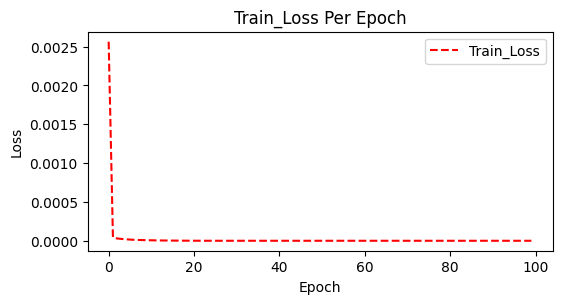

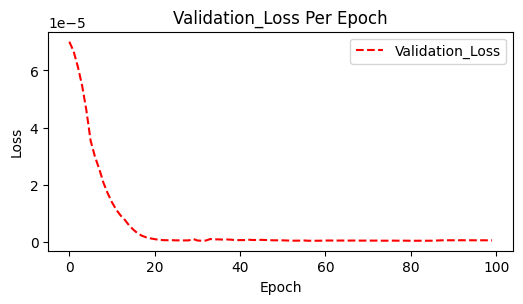

In [8]:
  # Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


model = LSTM(
    input_size=xfinai_config.lstm_model_config['input_size'],
    hidden_size=xfinai_config.lstm_model_config['hidden_size'],
    num_layers=xfinai_config.lstm_model_config['num_layers'],
    output_size=xfinai_config.lstm_model_config['output_size'],
    dropout_prob=xfinai_config.lstm_model_config['dropout_prob'],
    device = device
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), 
            lr=xfinai_config.lstm_model_config['learning_rate'], 
            weight_decay=xfinai_config.lstm_model_config['weight_decay'])
epochs = xfinai_config.lstm_model_config['epochs']

print(model)

train_losses, validation_losses,trained_model = train(train_dataloader_ic, val_dataloader_ic, model, criterion, optimizer, epochs)

save_model(trained_model)
plot_loss(train_losses, epochs,'Train_Loss',trained_model.name)   
plot_loss(validation_losses, epochs,'Validation_Loss',trained_model.name)    

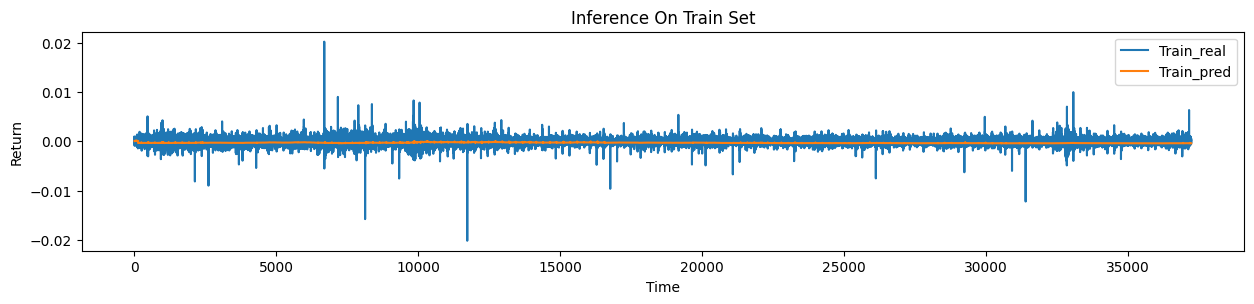

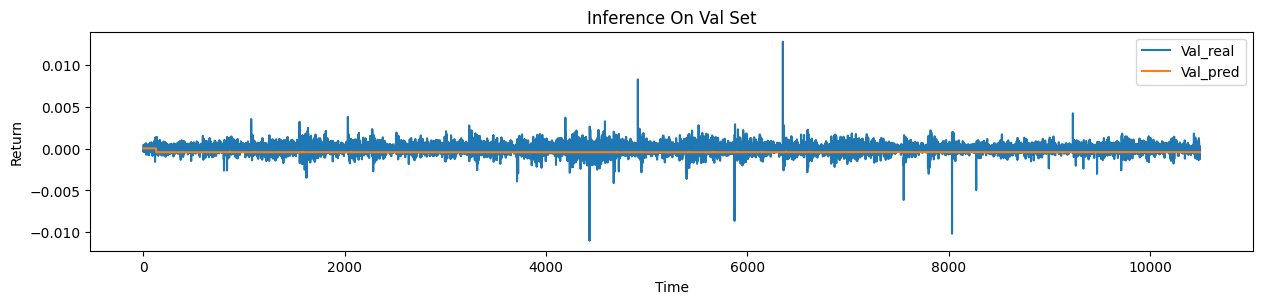

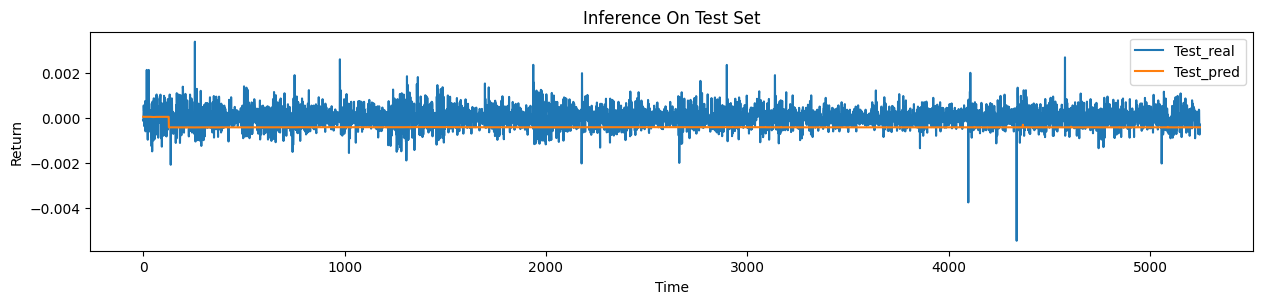

In [9]:
for dataloader, data_set_name in zip([train_dataloader_ic, val_dataloader_ic, test_dataloader_ic], ['Train','Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name, model_name=trained_model.name)